# Experiment 1 & 2

- Rank metrics for each model for store & upc. The metrics are the average over all folds. (total of 52 weeks)
- Plots over time
- Statistical tests to compare predictions from experiment 1 with experiment 2 


In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)


In [2]:
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())

full_search = list(itertools.product(stores, upcs))

date_ranges = make_dates(params['breakfast']['experiment_dates'])['test_end']

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Select a paid of store and upc:
# Currently only has 3 to 7.
store, upc = full_search[0]

In [4]:
# Aggregate all predictions of each model for exp1

all_stores_upc = {}
base_mae_rmse_ll = []

for store, upc in full_search:
    xgb_exp1 =[]
    xgb_exp2 =[]
    lstm_exp1 =[]
    lstm_exp2 =[]
    
    for fpath in glob(str(proj_path / f'data/04_results/*')):
        if ('olist' in fpath) | ('breakfast' in fpath):
            pass
        else:
            xgb_exp1.append(pd.read_csv(os.path.join(fpath,f'xgb_exp1_{store}_{upc}.csv')))
            xgb_exp2.append(pd.read_csv(os.path.join(fpath,f'xgb_exp2_{store}_{upc}.csv')))
            lstm_exp1.append(pd.read_csv(os.path.join(fpath,f'lstm_exp1_{store}_{upc}.csv')))
            lstm_exp2.append(pd.read_csv(os.path.join(fpath,f'lstm_exp2_{store}_{upc}.csv')))

    xgb_exp1 = pd.concat(xgb_exp1).reset_index(drop=True)
    xgb_exp2 = pd.concat(xgb_exp2).reset_index(drop=True)
    lstm_exp1 = pd.concat(lstm_exp1).reset_index(drop=True)
    lstm_exp2 = pd.concat(lstm_exp2).reset_index(drop=True)
    
    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'test_predictions':'y_pred_xgb',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb','y_true']]
    xgb_exp2 = xgb_exp2.rename(columns={'test_predictions':'y_pred_xgb_gtrend',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb_gtrend','y_true']]
    lstm_exp1['dates'] = xgb_exp1['dates']
    lstm_exp1.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred':'y_pred_lstm'})
    lstm_exp2['dates'] = xgb_exp1['dates']
    lstm_exp2.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp2 = lstm_exp2.rename(columns={'y_pred':'y_pred_lstm_gtrend'})
    
    xgb_exp1.set_index('dates', inplace=True)
    xgb_exp2.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    lstm_exp2.set_index('dates', inplace=True)

    base_metrics = pd.read_csv(proj_path / catalog['results']['dir'] / 'breakfast' / f'naive_training_{store}_{upc}.csv')

    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
                    xgb_exp2['y_pred_xgb_gtrend'],
                    lstm_exp1['y_pred_lstm'],
                    lstm_exp2['y_pred_lstm_gtrend']],axis=1)
    all_stores_upc[f'{store}_{upc}'] = df
    
    base_mae_rmse_ll.append({'store': store,
                             'upc':upc,
                             'base_mae':base_metrics['train_mae'].values[0],
                             'base_rmse':base_metrics['train_rmse'].values[0]})
    
base_mae_rmse = pd.DataFrame(base_mae_rmse_ll)

In [5]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_xgb_gtrends = []
    _metrics_lstm = []
    _metrics_lstm_gtrends = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_xgb_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_xgb_gtrend']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_lstm_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['xgb','xgb_gtrend','lstm','lstm_gtrend'],
                      'min_wape':[pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].max()],
                     'max_mae':[pd.DataFrame(_metrics_xgb)['mae'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mae'].max()],
                     'min_mae':[pd.DataFrame(_metrics_xgb)['mae'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mae'].min()]})


In [6]:
# metrics_df_xgb = pd.DataFrame()
metrics_df = pd.DataFrame()
metrics_mase_rmsse = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics_xgb = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_xgb_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])
        metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
        metrics_lstm_gtrends = get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend'])

        results = pd.DataFrame([metrics_xgb,
                                metrics_xgb_gtrends,
                                metrics_lstm,
                                metrics_lstm_gtrends], 
                           index=['xgb','xgb_gtrend','lstm','lstm_gtrend'])
        
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
        
        # Add rank for rmsse and mase
        results = results.merge(base_mae_rmse, how='left', on=['store','upc'])
        results['mase'] = results['mae'] / results['base_mae']
        results['rmsse'] = results['rmse'] / results['base_rmse']
        results['rank_rmsse'] = results.rank(axis=0)['rmsse']
        results['rank_mase'] = results.rank(axis=0)['mase']
        
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        results = results.merge(min_max_df, how='inner', on='model')  

        # Calculate the minimum and maximum of each fold
        metrics_df = metrics_df.append(results).reset_index(drop=True)

In [7]:
metrics_df[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0           xgb   2277  1600027527  0.957258  0.801183        3.0         2.0
1    xgb_gtrend   2277  1600027527  1.063620  0.883417        4.0         4.0
2          lstm   2277  1600027527  0.934310  0.832479        2.0         3.0
3   lstm_gtrend   2277  1600027527  0.855197  0.785065        1.0         1.0
4           xgb   2277  3800031838  1.218715  0.979685        4.0         4.0
..          ...    ...         ...       ...       ...        ...         ...
91  lstm_gtrend  25229  1111009477  1.106564  1.016519        3.5         3.5
92          xgb  25229  7192100339  0.853070  0.738186        3.5         3.5
93   xgb_gtrend  25229  7192100339  0.830626  0.725418        1.5         1.5
94         lstm  25229  7192100339  0.853070  0.738186        3.5         3.5
95  lstm_gtrend  25229  7192100339  0.830626  0.725418        1.5         1.5

[96 rows x 7 columns]

In [8]:
metrics_df

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model          wape        rmse        r2      mape        mae  \
0           xgb  11857.916820   96.616609 -0.084401  0.231673  55.730769   
1    xgb_gtrend  12551.356965  106.533491 -0.318435  0.260960  61.923077   
2          lstm  12329.506846  100.390743 -0.170776  0.222847  54.394731   
3   lstm_gtrend  11602.964490   94.672951 -0.041210  0.208543  49.788872   
4           xgb   4341.408809   73.455245 -0.914716  0.493060  46.903846   
..          ...           ...         ...       ...       ...        ...   
91  lstm_gtrend    480.266827   18.993489 -0.502043  0.324283  15.507054   
92          xgb    357.240017   14.731200 -0.106744  0.301660  11.387904   
93   xgb_gtrend    349.290854   14.476395 -0.068789  0.292107  11.088287   
94         lstm    357.240017   14.731200 -0.106744  0.301660  11.387904   
95  lstm_gtrend    349.290854   14.476395 -0.068789  0.292107  11.088287   

    store         upc  rank_mape  rank_wape  ...    min_wape  min_rmse  \
0    2277  1600027527        3.0        2.0  ...  122.295918  5.431390   
1    2277  1600027527        4.0        4.0  ...  136.514286  9.721111   
2    2277  1600027527        2.0        3.0  ...  108.549113  5.593485   
3    2277  1600027527        1.0        1.0  ...  106.248917  5.096696   
4    2277  3800031838        4.0        4.0  ...  122.295918  5.431390   
..    ...         ...        ...        ...  ...         ...       ...   
91  25229  1111009477        3.5        3.5  ...  106.248917  5.096696   
92  25229  7192100339        3.5        3.5  ...  122.295918  5.431390   
93  25229  7192100339        1.5        1.5  ...  136.514286  9.721111   
94  25229  7192100339        3.5        3.5  ...  108.549113  5.593485   
95  25229  7192100339        1.5        1.5  ...  106.248917  5.096696   

       min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  \
0  -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248   
1  -20.682927  0.236765  1320.638462  29.287369 -0.120628  0.470874   
2   -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750   
3   -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428   
4  -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248   
..        ...       ...          ...        ...       ...       ...   
91  -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428   
92 -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248   
93 -20.682927  0.236765  1320.638462  29.287369 -0.120628  0.470874   
94  -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750   
95  -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428   

      max_mae   min_mae  
0   28.500000  5.000000  
1   25.750000  8.000000  
2   22.104318  4.934811  
3   21.154967  4.656193  
4   28.500000  5.000000  
..        ...       ...  
91  21.154967  4.656193  
92  28.500000  5.000000  
93  25.750000  8.000000  
94  22.104318  4.934811  
95  21.154967  4.656193  

[96 rows x 28 columns]

In [9]:
metrics_df_xgb = pd.DataFrame()
metrics_df_lstm = pd.DataFrame()
metrics_df_xgb_mase_rmsse = pd.DataFrame()
metrics_df_lstm_mase_rmsse = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])

        results = pd.DataFrame([metrics,
                                metrics_gtrends], 
                                index=[model,f'{model}_gtrend'])
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
        
        # Add rank for rmsse and mase
        results = results.merge(base_mae_rmse, how='left', on=['store', 'upc'])
        results['mase'] = results['mae'] / results['base_mae']
        results['rmsse'] = results['rmse'] / results['base_rmse']
        results['rank_rmsse'] = results.rank(axis=0)['rmsse']
        results['rank_mase'] = results.rank(axis=0)['mase']
        
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        # left to only include model specific
        results = results.merge(min_max_df, how='left',on='model')  

        # Calculate the minimum and maximum of each fold.
        if model == 'xgb':
            metrics_df_xgb = metrics_df_xgb.append(results).reset_index(drop=True)
            metrics_df_xgb_mase_rmsse = metrics_df_xgb_mase_rmsse.append(results).reset_index(drop=True)

        if model =='lstm':
            metrics_df_lstm = metrics_df_lstm.append(results).reset_index(drop=True)
            metrics_df_lstm_mase_rmsse = metrics_df_lstm_mase_rmsse.append(results).reset_index(drop=True)


C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
metrics_df_xgb_mase_rmsse[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0          xgb   2277  1600027527  0.957258  0.801183        1.0         1.0
1   xgb_gtrend   2277  1600027527  1.063620  0.883417        2.0         2.0
2          xgb   2277  3800031838  1.218715  0.979685        2.0         2.0
3   xgb_gtrend   2277  3800031838  1.111285  0.885488        1.0         1.0
4          xgb   2277  1111009477  1.506113  1.420591        1.0         1.0
5   xgb_gtrend   2277  1111009477  1.539317  1.448103        2.0         2.0
6          xgb   2277  7192100339  1.233069  1.108042        1.0         1.0
7   xgb_gtrend   2277  7192100339  1.438580  1.240360        2.0         2.0
8          xgb    389  1600027527  0.795395  0.732820        1.0         2.0
9   xgb_gtrend    389  1600027527  0.829622  0.702287        2.0         1.0
10         xgb    389  3800031838  1.079002  1.055477        2.0         2.0
11  xgb_gtrend    389  3800031838  0.890333  0.976847        1.0         1.0
12         xgb    389  1111009477  1.100712  1.122712        1.0         1.0
13  xgb_gtrend    389  1111009477  1.142372  1.133566        2.0         2.0
14         xgb    389  7192100339  1.416217  1.294296        1.0         2.0
15  xgb_gtrend    389  7192100339  1.478566  1.231103        2.0         1.0
16         xgb  25229  1600027527  1.187492  0.999165        1.0         1.0
17  xgb_gtrend  25229  1600027527  1.528696  1.168092        2.0         2.0
18         xgb  25229  3800031838  1.055292  0.892055        2.0         2.0
19  xgb_gtrend  25229  3800031838  0.953871  0.775542        1.0         1.0
20         xgb  25229  1111009477  1.117039  1.092290        2.0         1.0
21  xgb_gtrend  25229  1111009477  1.090965  1.105698        1.0         2.0
22         xgb  25229  7192100339  1.269152  1.076656        2.0         2.0
23  xgb_gtrend  25229  7192100339  0.973833  0.881901        1.0         1.0

In [11]:
metrics_df_lstm

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model          wape        rmse        r2      mape        mae  \
0          lstm  12329.506846  100.390743 -0.170776  0.222847  54.394731   
1   lstm_gtrend  11602.964490   94.672951 -0.041210  0.208543  49.788872   
2          lstm   3706.028024   55.453772 -0.091242  0.285782  30.386227   
3   lstm_gtrend   3795.068905   57.015077 -0.153555  0.312744  31.807184   
4          lstm   6095.299925   47.394208 -0.256617  0.172345  34.456282   
5   lstm_gtrend   6485.407017   49.648647 -0.379010  0.185161  37.078577   
6          lstm   1717.679181   36.425381 -0.002024  0.546008  27.906022   
7   lstm_gtrend   1661.970724   37.244318 -0.047587  0.600847  29.001207   
8          lstm   5510.048961   70.339678 -0.068509  0.541170  46.507932   
9   lstm_gtrend   6523.996769   81.247820 -0.425611  0.470797  45.776792   
10         lstm   4616.549246   68.317803 -0.065417  0.427679  34.109942   
11  lstm_gtrend   4837.535810   74.762341 -0.275903  0.651924  44.003449   
12         lstm   1227.433281   20.711683 -0.105599  0.161557  16.118138   
13  lstm_gtrend   1432.430120   22.330608 -0.285192  0.162246  16.958715   
14         lstm    930.936888   29.736560 -0.017332  0.714194  21.201844   
15  lstm_gtrend   1015.828112   32.592970 -0.222163  0.796290  22.750325   
16         lstm   5627.313178   73.113273 -0.003453  0.371022  37.279027   
17  lstm_gtrend   5653.167719   73.843655 -0.023602  0.404111  39.760353   
18         lstm   1972.516971   41.183184 -0.098334  0.258114  23.092000   
19  lstm_gtrend   1902.284998   41.555433 -0.118279  0.306235  26.405889   
20         lstm    451.307723   16.886844 -0.187326  0.302901  14.517940   
21  lstm_gtrend    480.266827   18.993489 -0.502043  0.324283  15.507054   
22         lstm    357.240017   14.731200 -0.106744  0.301660  11.387904   
23  lstm_gtrend    349.290854   14.476395 -0.068789  0.292107  11.088287   

    store         upc  rank_mape  rank_wape  ...    min_wape  min_rmse  \
0    2277  1600027527        2.0        2.0  ...  108.549113  5.593485   
1    2277  1600027527        1.0        1.0  ...  106.248917  5.096696   
2    2277  3800031838        1.0        1.0  ...  108.549113  5.593485   
3    2277  3800031838        2.0        2.0  ...  106.248917  5.096696   
4    2277  1111009477        1.0        1.0  ...  108.549113  5.593485   
5    2277  1111009477        2.0        2.0  ...  106.248917  5.096696   
6    2277  7192100339        1.0        2.0  ...  108.549113  5.593485   
7    2277  7192100339        2.0        1.0  ...  106.248917  5.096696   
8     389  1600027527        2.0        1.0  ...  108.549113  5.593485   
9     389  1600027527        1.0        2.0  ...  106.248917  5.096696   
10    389  3800031838        1.0        1.0  ...  108.549113  5.593485   
11    389  3800031838        2.0        2.0  ...  106.248917  5.096696   
12    389  1111009477        1.0        1.0  ...  108.549113  5.593485   
13    389  1111009477        2.0        2.0  ...  106.248917  5.096696   
14    389  7192100339        1.0        1.0  ...  108.549113  5.593485   
15    389  7192100339        2.0        2.0  ...  106.248917  5.096696   
16  25229  1600027527        1.0        1.0  ...  108.549113  5.593485   
17  25229  1600027527        2.0        2.0  ...  106.248917  5.096696   
18  25229  3800031838        1.0        2.0  ...  108.549113  5.593485   
19  25229  3800031838        2.0        1.0  ...  106.248917  5.096696   
20  25229  1111009477        1.0        1.0  ...  108.549113  5.593485   
21  25229  1111009477        2.0        2.0  ...  106.248917  5.096696   
22  25229  7192100339        2.0        2.0  ...  108.549113  5.593485   
23  25229  7192100339        1.0        1.0  ...  106.248917  5.096696   

      min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape    max_mae  \
0  -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750  22.104318   
1  -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428  21.154967   
2  -7.036332  0

In [12]:
metrics_df_lstm_mase_rmsse[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0          lstm   2277  1600027527  0.934310  0.832479        2.0         2.0
1   lstm_gtrend   2277  1600027527  0.855197  0.785065        1.0         1.0
2          lstm   2277  3800031838  0.789534  0.739597        1.0         1.0
3   lstm_gtrend   2277  3800031838  0.826455  0.760420        2.0         2.0
4          lstm   2277  1111009477  1.189834  1.188514        1.0         1.0
5   lstm_gtrend   2277  1111009477  1.280386  1.245049        2.0         2.0
6          lstm   2277  7192100339  1.050072  0.878360        1.0         1.0
7   lstm_gtrend   2277  7192100339  1.091283  0.898108        2.0         2.0
8          lstm    389  1600027527  0.899716  0.590125        2.0         1.0
9   lstm_gtrend    389  1600027527  0.885572  0.681641        1.0         2.0
10         lstm    389  3800031838  0.921890  0.948488        1.0         1.0
11  lstm_gtrend    389  3800031838  1.189282  1.037960        2.0         2.0
12         lstm    389  1111009477  0.918879  0.887241        1.0         1.0
13  lstm_gtrend    389  1111009477  0.966799  0.956592        2.0         2.0
14         lstm    389  7192100339  1.091107  0.953522        1.0         1.0
15  lstm_gtrend    389  7192100339  1.170796  1.045114        2.0         2.0
16         lstm  25229  1600027527  1.002161  0.847535        1.0         1.0
17  lstm_gtrend  25229  1600027527  1.068866  0.856002        2.0         2.0
18         lstm  25229  3800031838  0.770789  0.668055        1.0         1.0
19  lstm_gtrend  25229  3800031838  0.881404  0.674094        2.0         2.0
20         lstm  25229  1111009477  1.035982  0.903772        1.0         1.0
21  lstm_gtrend  25229  1111009477  1.106564  1.016519        2.0         2.0
22         lstm  25229  7192100339  0.853070  0.738186        2.0         2.0
23  lstm_gtrend  25229  7192100339  0.830626  0.725418        1.0         1.0

In [13]:
metrics_df_xgb

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model          wape        rmse        r2      mape        mae  \
0          xgb  11857.916820   96.616609 -0.084401  0.231673  55.730769   
1   xgb_gtrend  12551.356965  106.533491 -0.318435  0.260960  61.923077   
2          xgb   4341.408809   73.455245 -0.914716  0.493060  46.903846   
3   xgb_gtrend   4282.433485   66.392481 -0.564216  0.413846  42.769231   
4          xgb   7343.829475   56.648715 -0.795282  0.214849  43.615385   
5   xgb_gtrend   6955.729525   57.745796 -0.865491  0.244130  44.576923   
6          xgb   2144.193093   45.950224 -0.594576  0.533829  32.769231   
7   xgb_gtrend   2275.801151   51.437415 -0.998151  0.713300  38.230769   
8          xgb   6339.453799   87.348110 -0.647724  0.371145  41.115385   
9   xgb_gtrend   5198.635985   83.708744 -0.513280  0.445702  42.884615   
10         xgb   5006.680451   76.024035 -0.319331  0.495279  39.923077   
11  xgb_gtrend   4810.600637   70.360473 -0.130080  0.331758  32.942308   
12         xgb   1395.112443   26.208484 -0.770316  0.196807  19.307692   
13  xgb_gtrend   1636.826697   26.461874 -0.804713  0.190437  20.038462   
14         xgb   1177.498749   40.363969 -0.874429  0.780780  27.519231   
15  xgb_gtrend    972.312226   38.393209 -0.695860  1.013201  28.730769   
16         xgb   6182.928399   86.193767 -0.394622  0.416937  44.173077   
17  xgb_gtrend   6033.365304  100.766390 -0.906058  0.567879  56.865385   
18         xgb   2381.890521   54.991957 -0.958361  0.345120  31.615385   
19  xgb_gtrend   2188.255474   47.809317 -0.480197  0.327519  28.576923   
20         xgb    485.146477   20.409274 -0.734316  0.325819  15.653846   
21  xgb_gtrend    563.373113   20.659790 -0.777153  0.295508  15.288462   
22         xgb    463.989183   21.485684 -1.354341  0.469173  16.942308   
23  xgb_gtrend    418.225000   17.599170 -0.579630  0.315692  13.000000   

    store         upc  rank_mape  rank_wape  ...    min_wape  min_rmse  \
0    2277  1600027527        1.0        1.0  ...  122.295918  5.431390   
1    2277  1600027527        2.0        2.0  ...  136.514286  9.721111   
2    2277  3800031838        2.0        2.0  ...  122.295918  5.431390   
3    2277  3800031838        1.0        1.0  ...  136.514286  9.721111   
4    2277  1111009477        1.0        2.0  ...  122.295918  5.431390   
5    2277  1111009477        2.0        1.0  ...  136.514286  9.721111   
6    2277  7192100339        1.0        1.0  ...  122.295918  5.431390   
7    2277  7192100339        2.0        2.0  ...  136.514286  9.721111   
8     389  1600027527        1.0        2.0  ...  122.295918  5.431390   
9     389  1600027527        2.0        1.0  ...  136.514286  9.721111   
10    389  3800031838        2.0        2.0  ...  122.295918  5.431390   
11    389  3800031838        1.0        1.0  ...  136.514286  9.721111   
12    389  1111009477        2.0        1.0  ...  122.295918  5.431390   
13    389  1111009477        1.0        2.0  ...  136.514286  9.721111   
14    389  7192100339        1.0        2.0  ...  122.295918  5.431390   
15    389  7192100339        2.0        1.0  ...  136.514286  9.721111   
16  25229  1600027527        1.0        2.0  ...  122.295918  5.431390   
17  25229  1600027527        2.0        1.0  ...  136.514286  9.721111   
18  25229  3800031838        2.0        2.0  ...  122.295918  5.431390   
19  25229  3800031838        1.0        1.0  ...  136.514286  9.721111   
20  25229  1111009477        2.0        1.0  ...  122.295918  5.431390   
21  25229  1111009477        1.0        2.0  ...  136.514286  9.721111   
22  25229  7192100339        2.0        2.0  ...  122.295918  5.431390   
23  25229  7192100339        1.0        1.0  ...  136.514286  9.721111   

       min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  max_mae  \
0  -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248    28.50   
1  -20.682927  0.236765  1320.638462  29.287369 -0.120628  0.470874    25.75   
2  -25.787879  0.154987  1400.350000  33.3

In [14]:
all_dfs_xgb = []
all_dfs_lstm = []

for metric in ['mape','rmse','wape','r2','mase','rmsse']:
    # Do this for xgb
    rank_df = pd.DataFrame(metrics_df_xgb.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_xgb.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    
    # Do this for lstm
    rank_df = pd.DataFrame(metrics_df_lstm.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_lstm.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# View combined of the ranks for each metrics per model
# metrics_df.drop(columns=['rank_mape','rank_wape', 'rank_rmse','rank_r2'])

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
pd.concat(all_dfs_xgb,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2  \
model                                                                    
xgb              6       6       6       6       4       8     6     6   
xgb_gtrend       6       6       6       6       8       4     6     6   

            mase_1  mase_2  rmsse_1  rmsse_2  
model                                         
xgb              7       5        6        6  
xgb_gtrend       5       7        6        6

In [17]:
pd.concat(all_dfs_lstm,axis=1)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2  \
model                                                                     
lstm              9       3      10       2       8       4    10     2   
lstm_gtrend       3       9       2      10       4       8     2    10   

             mase_1  mase_2  rmsse_1  rmsse_2  
model                                          
lstm              9       3       10        2  
lstm_gtrend       3       9        2       10

In [18]:
# View individual ranks for each metrics per model
# You can switch all_dfs_xgb for all_dfs_lstm
for df_metric in all_dfs_xgb: # all_dfs_lstm
    display(df_metric)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rank_mape   mape_1  mape_2
model                     
xgb              6       6
xgb_gtrend       6       6

rank_rmse   rmse_1  rmse_2
model                     
xgb              6       6
xgb_gtrend       6       6

rank_wape   wape_1  wape_2
model                     
xgb              4       8
xgb_gtrend       8       4

rank_r2     r2_1  r2_2
model                 
xgb            6     6
xgb_gtrend     6     6

rank_mase   mase_1  mase_2
model                     
xgb              7       5
xgb_gtrend       5       7

rank_rmsse  rmsse_1  rmsse_2
model                       
xgb               6        6
xgb_gtrend        6        6

In [19]:
lookup_products = pd.read_csv(os.path.join(proj_path, 
                                           catalog['output_dir']['dir'], 
                                           catalog['output_dir']['products']))

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


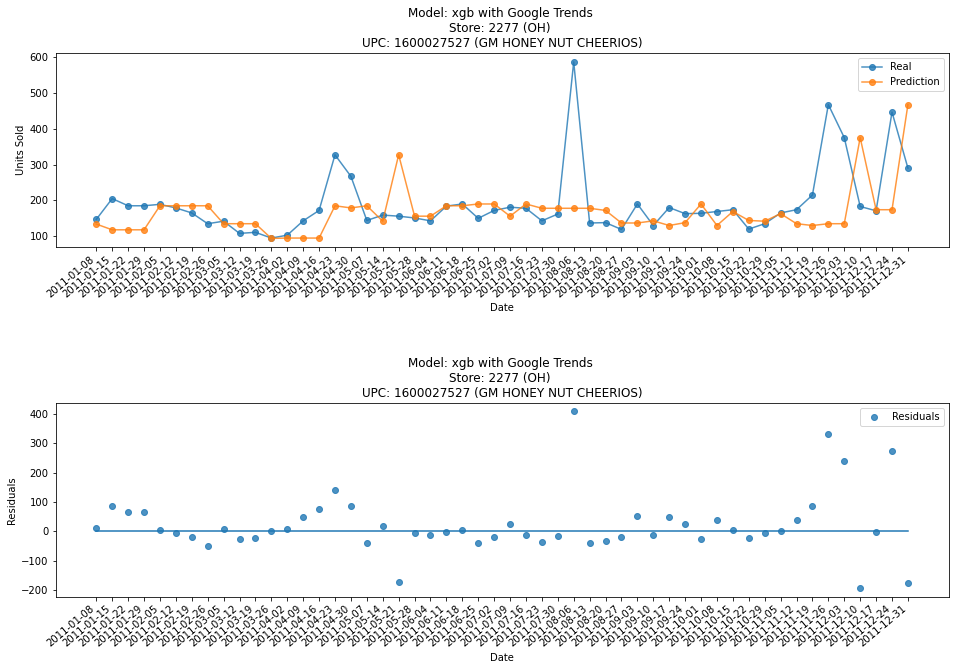

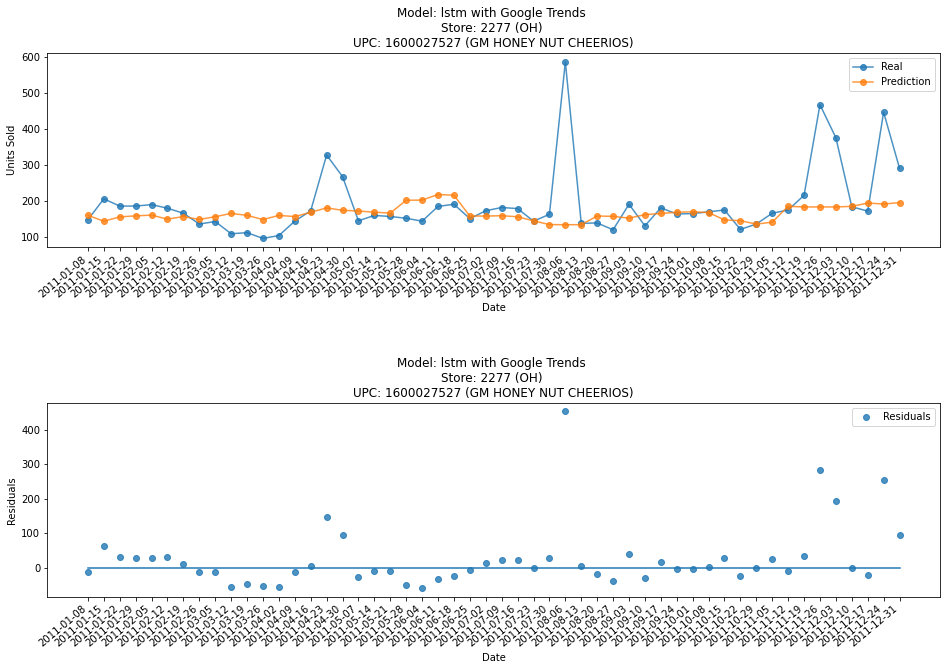

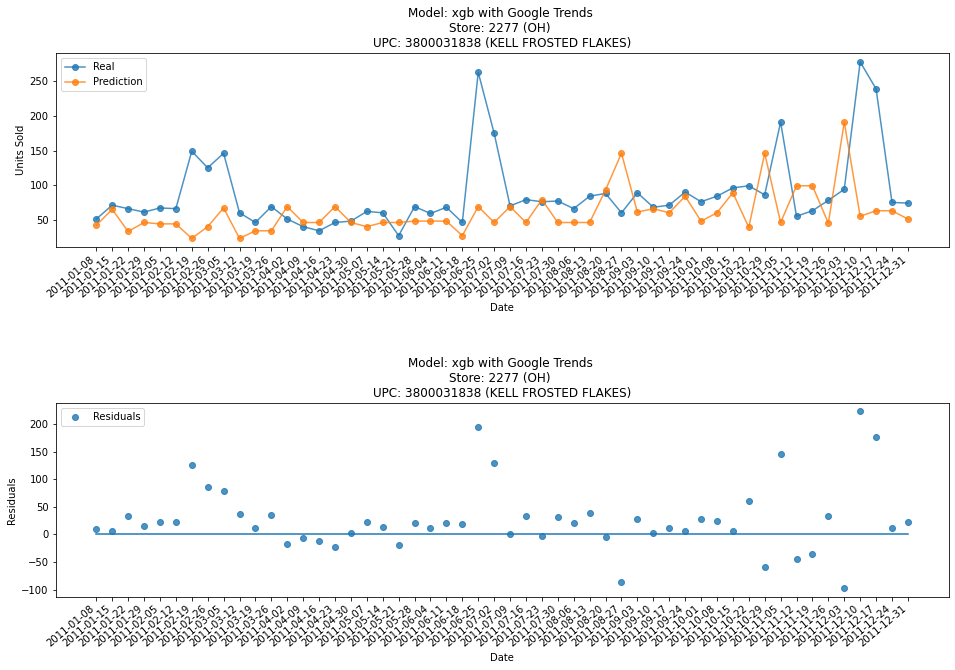

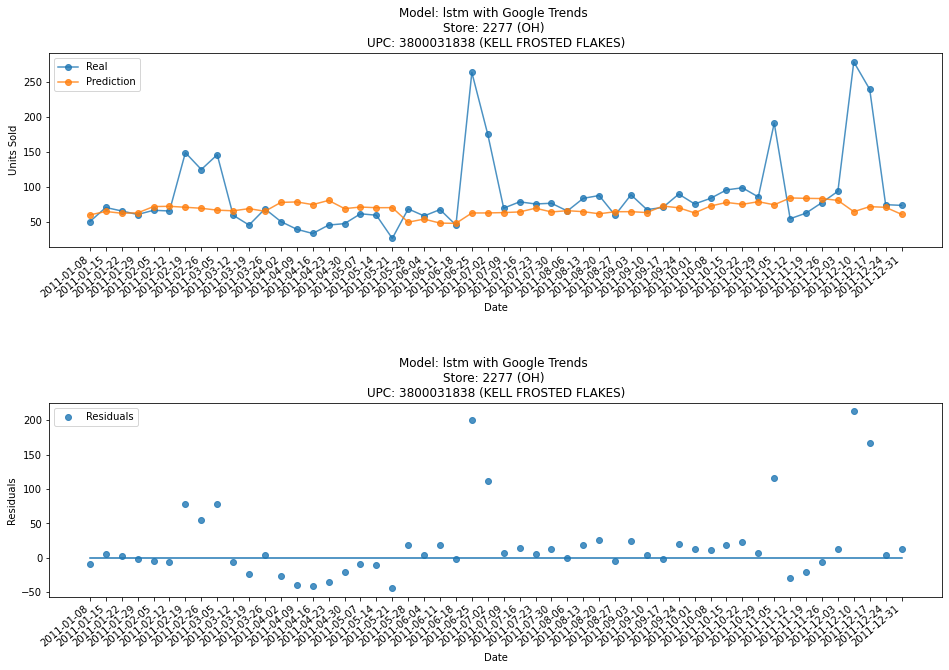

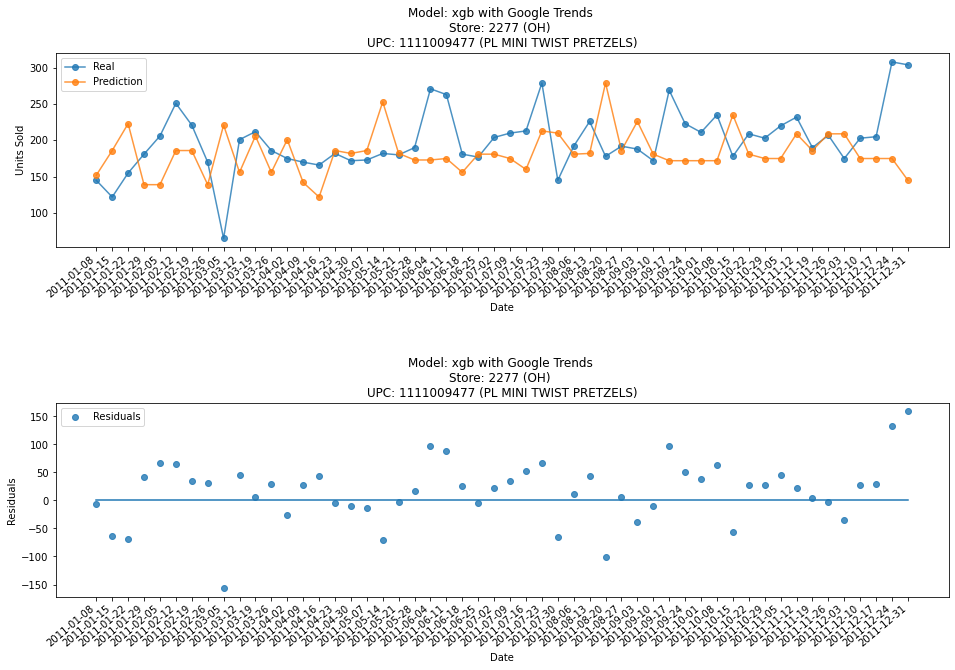

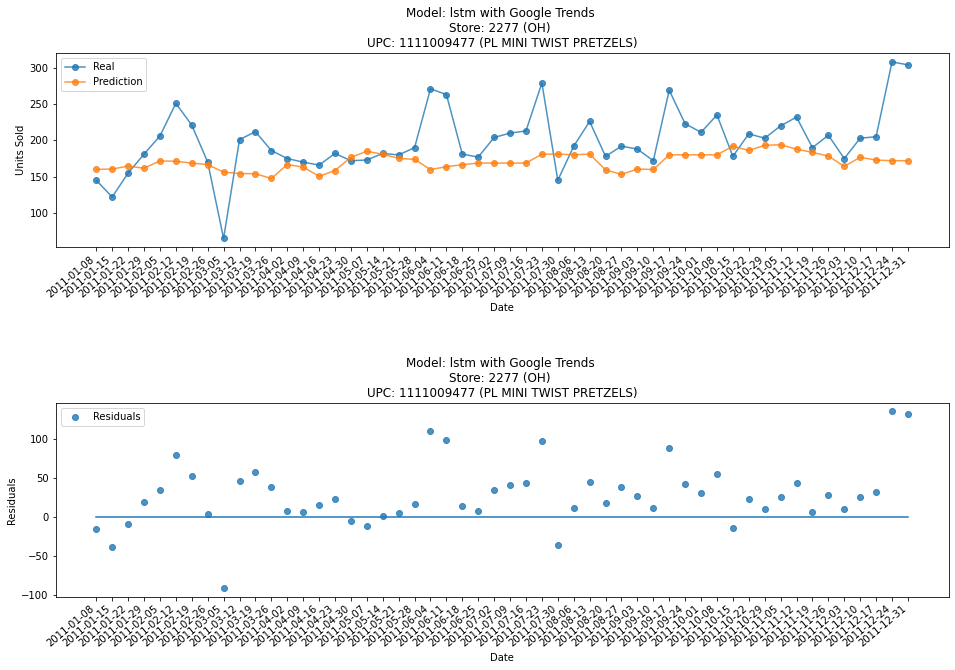

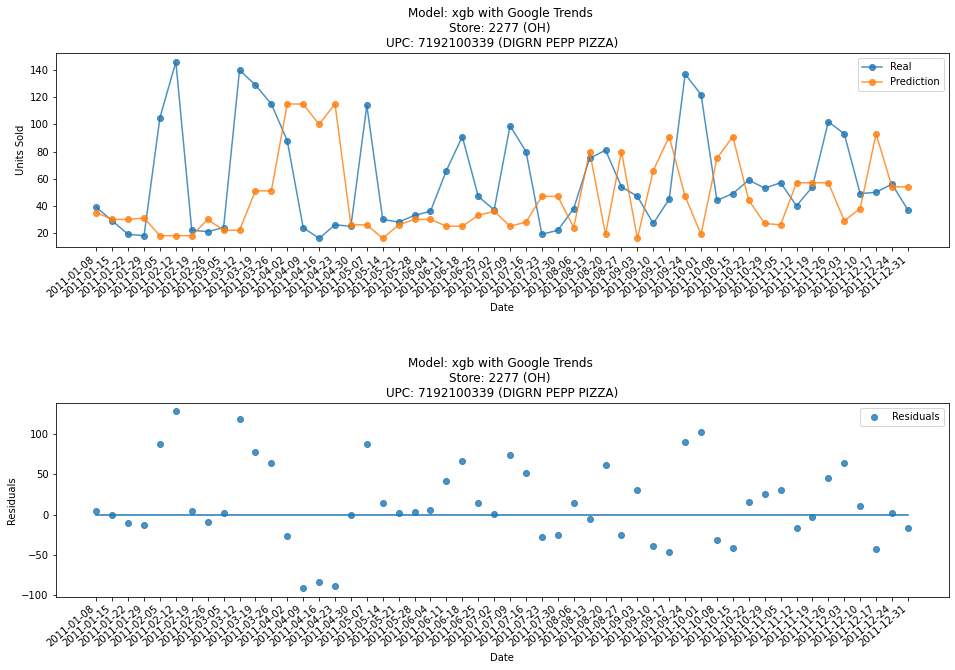

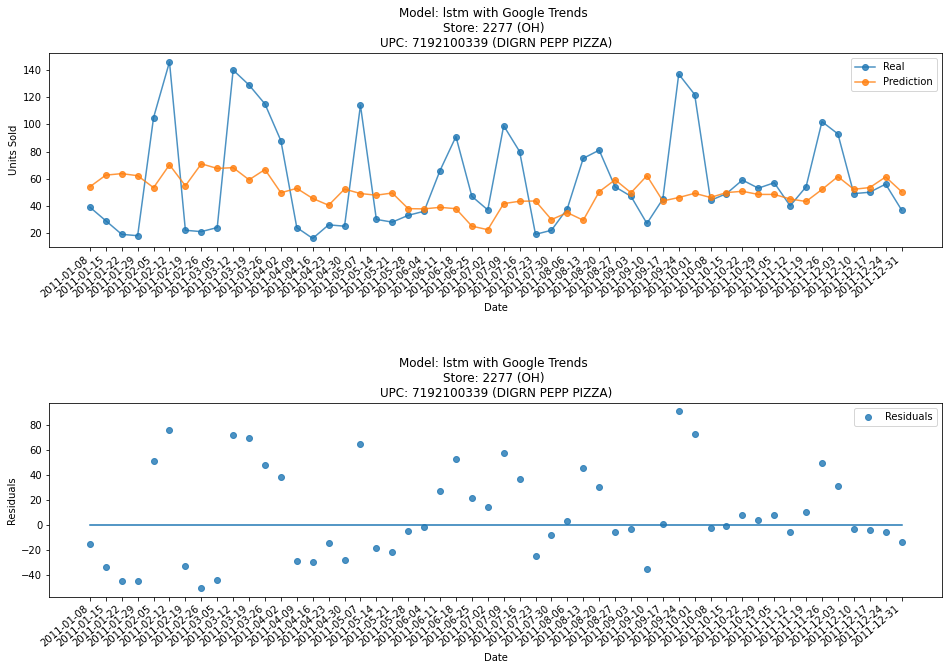

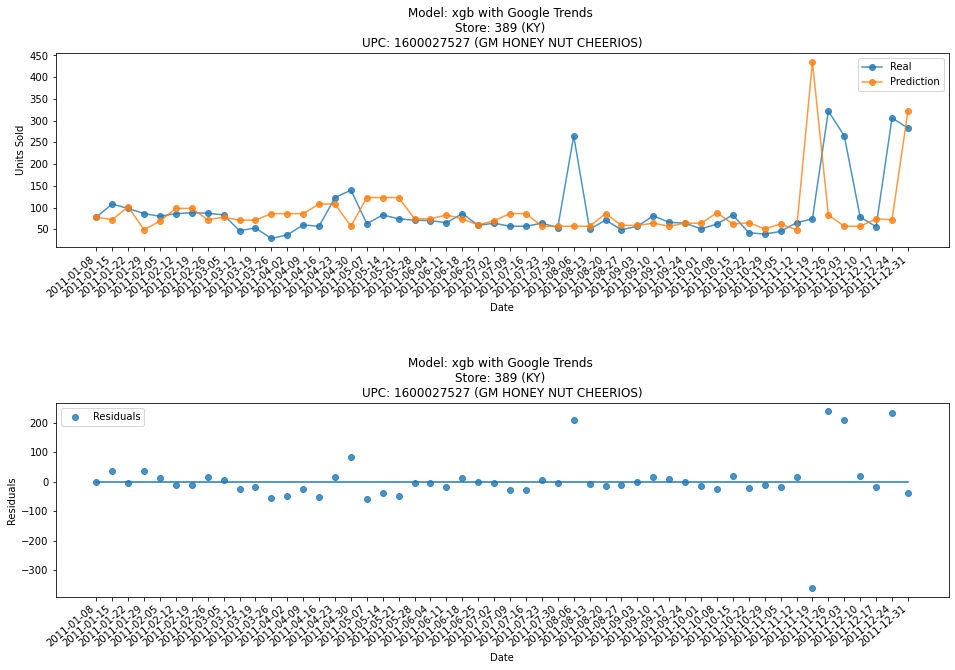

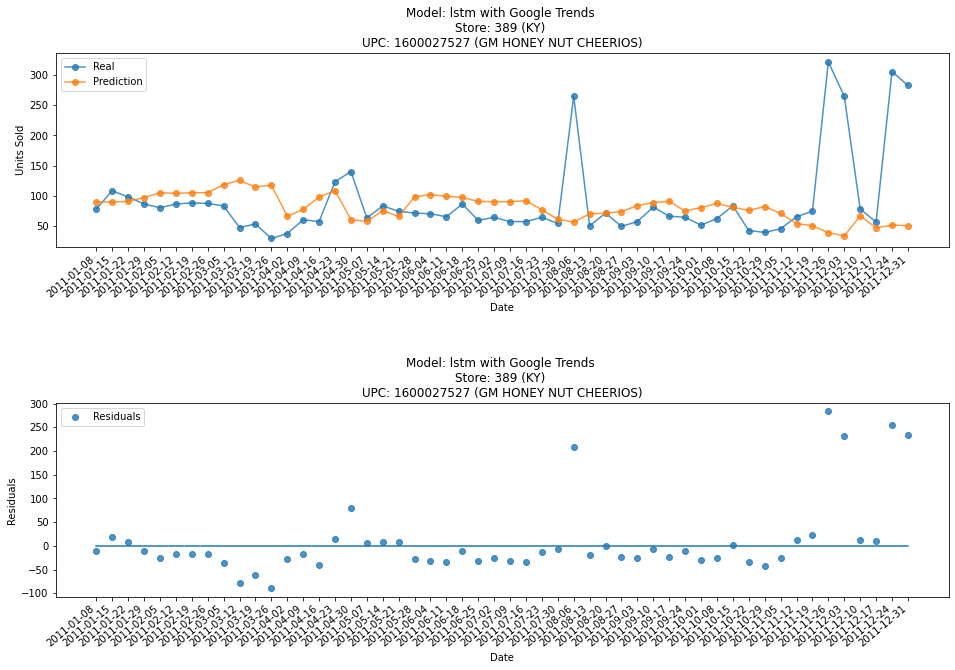

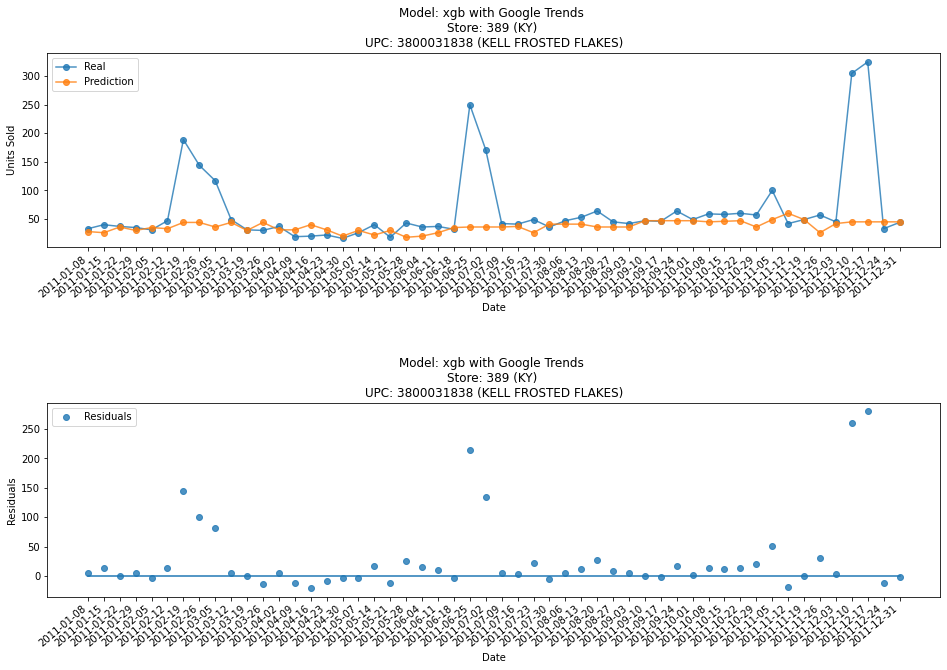

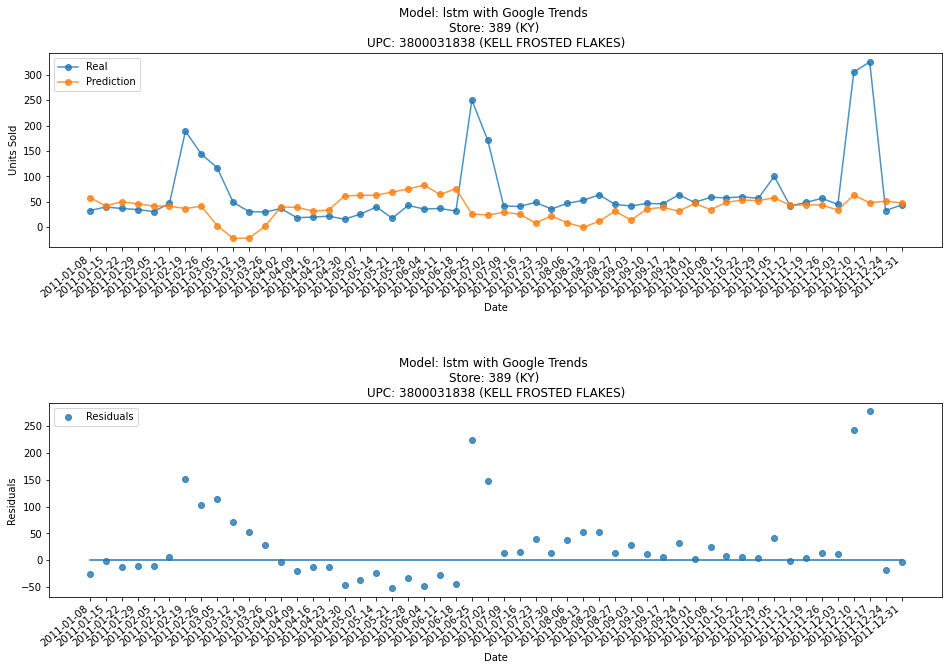

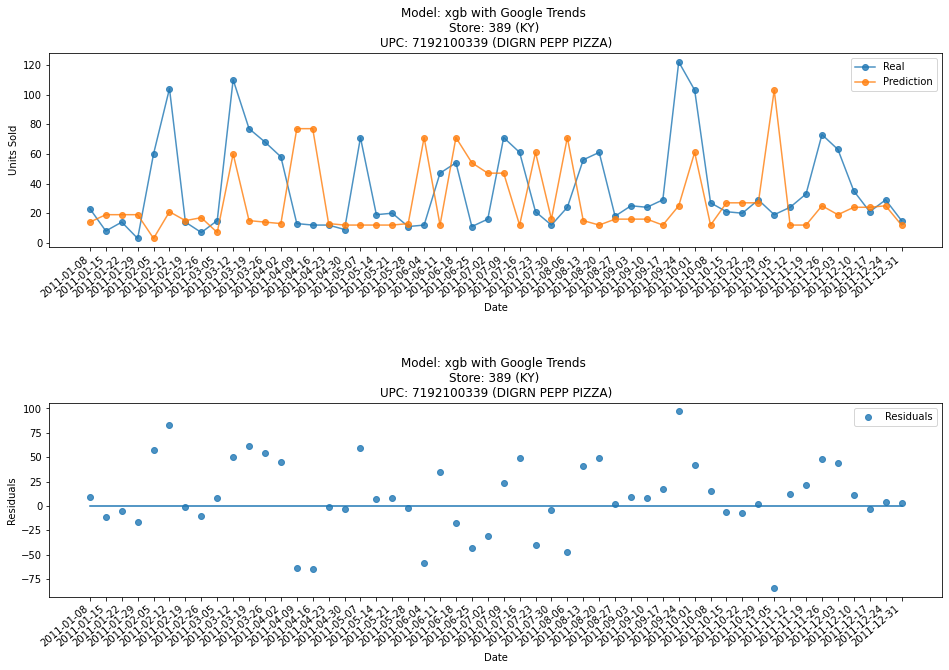

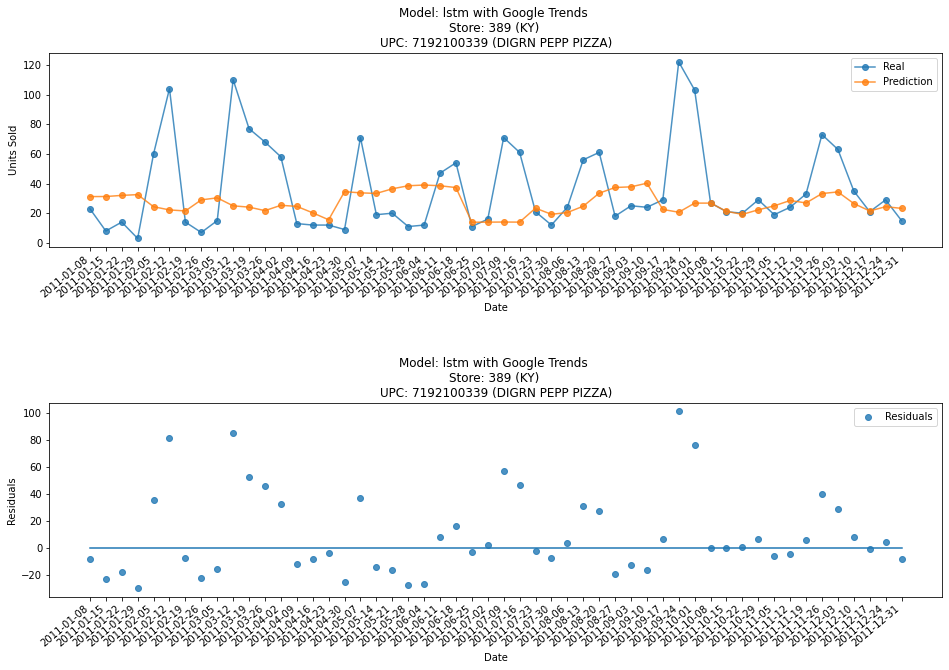

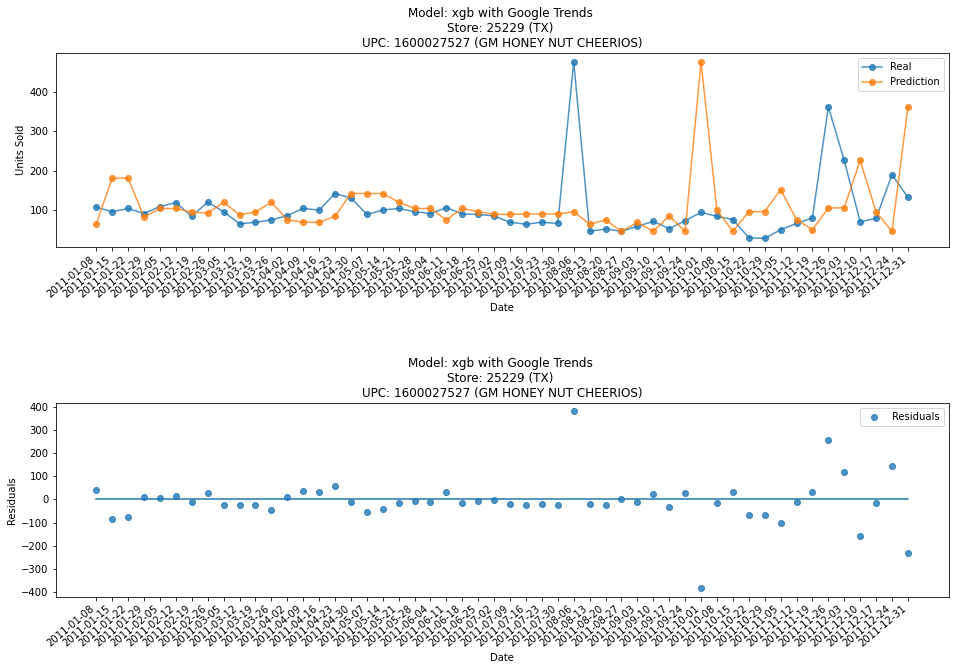

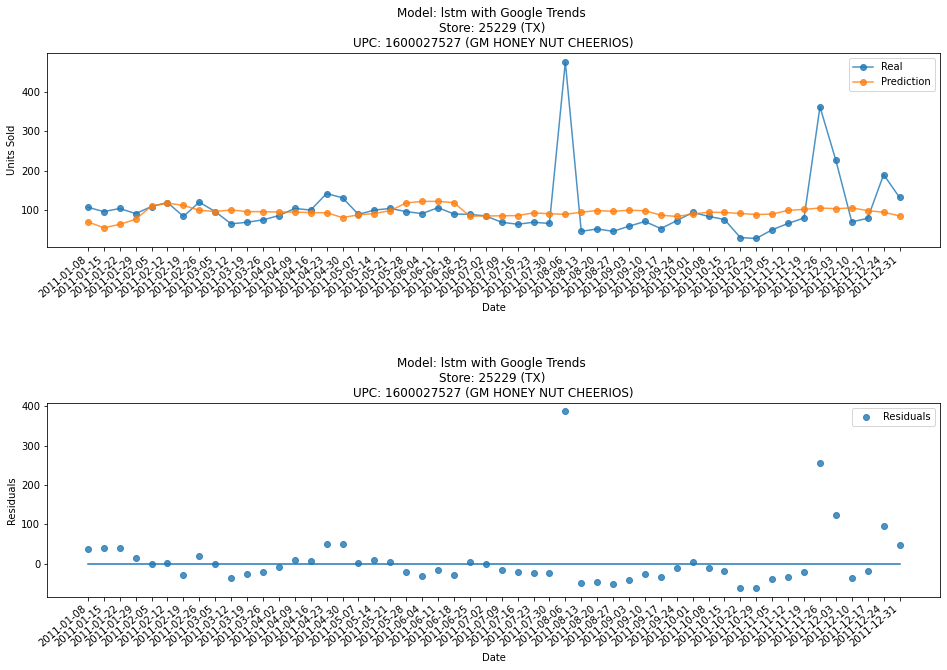

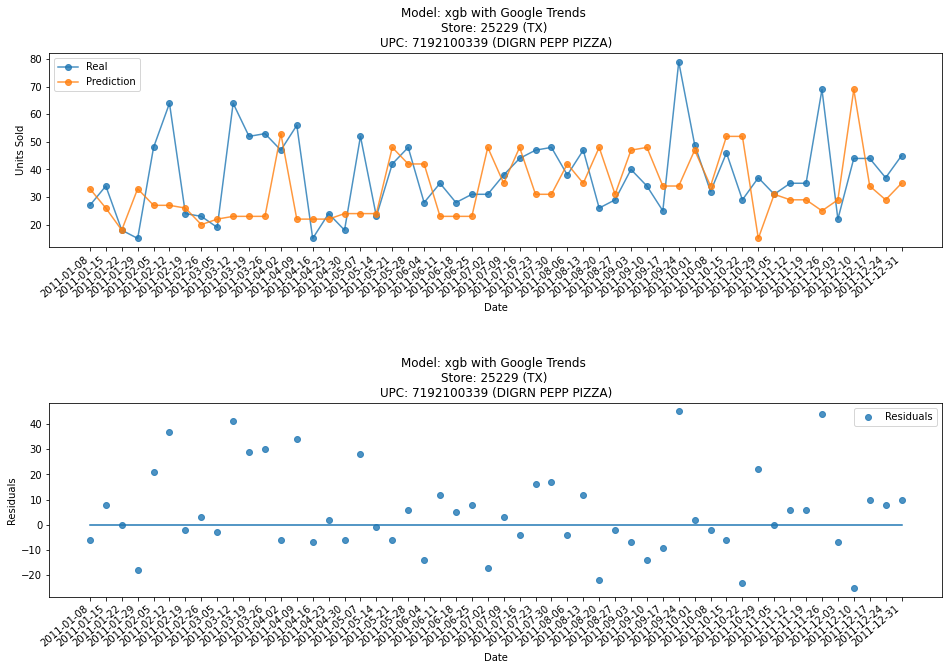

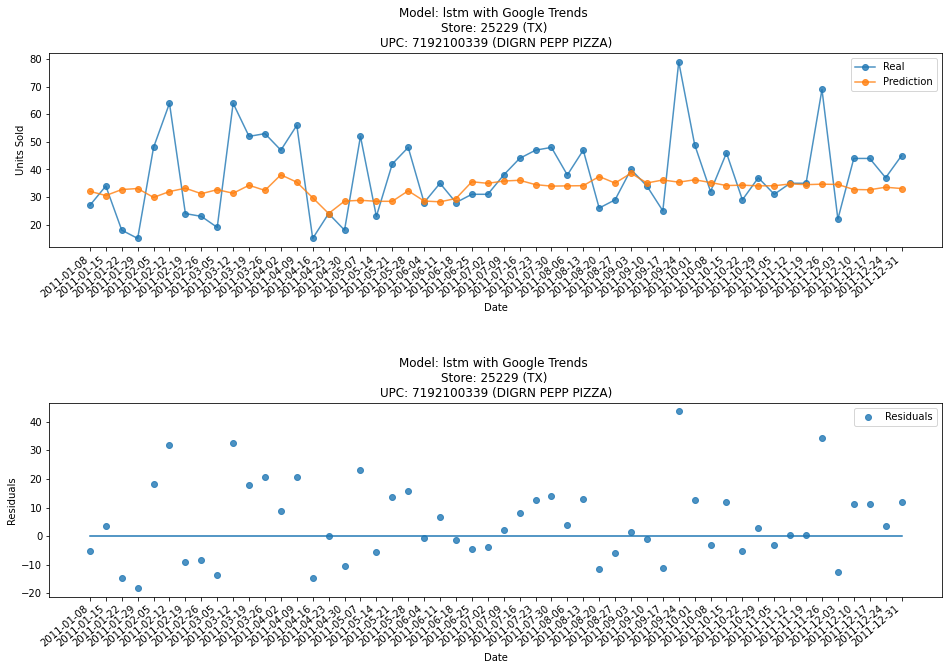

In [20]:
# Plot the forecast for each model (Only Google Trends)
for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecast
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}_gtrend'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}_gtrend']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()
        
    print('\n\n\n')

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


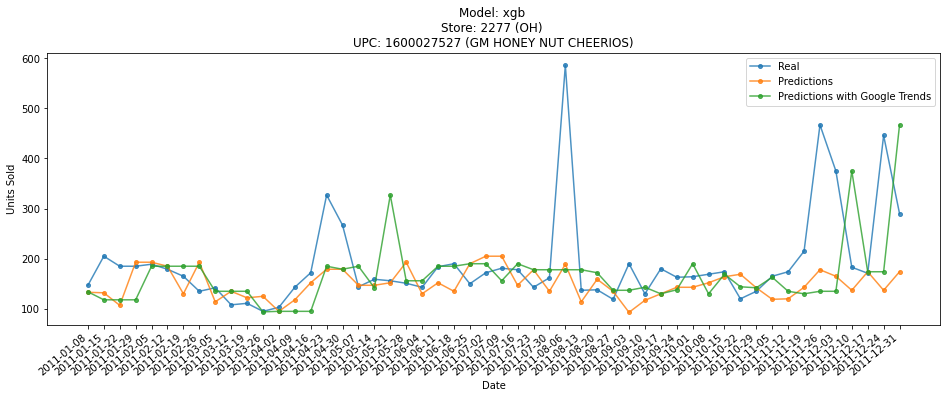

Std xgb: 28.85 and with Google Trends: 64.03


Std lstm: 7.32 and with Google Trends: 20.06






Std xgb: 41.64 and with Google Trends: 31.17


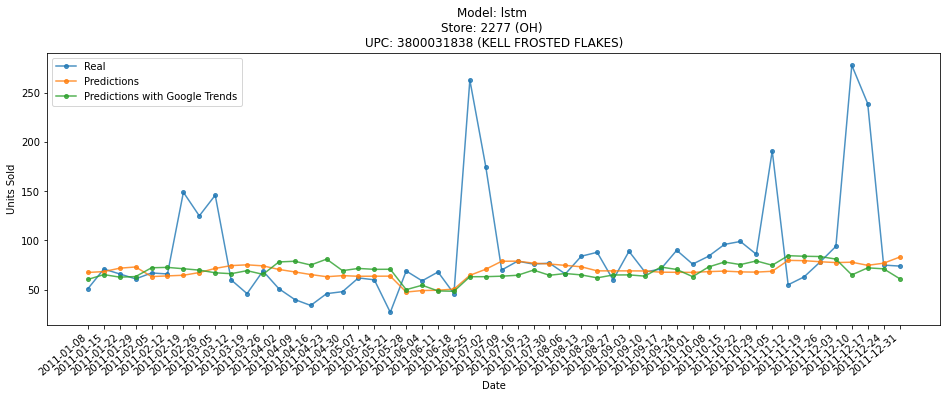

Std lstm: 7.78 and with Google Trends: 8.28






Std xgb: 28.13 and with Google Trends: 29.30


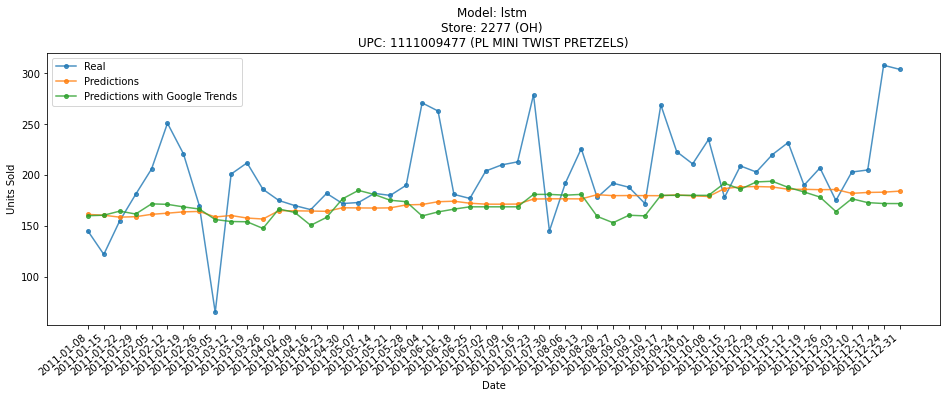

Std lstm: 9.68 and with Google Trends: 11.38






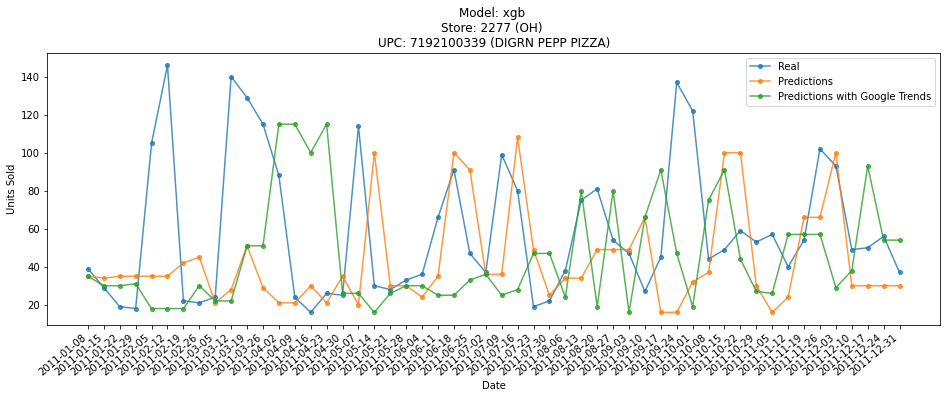

Std xgb: 25.43 and with Google Trends: 28.23


Std lstm: 5.05 and with Google Trends: 11.16






Std xgb: 46.65 and with Google Trends: 62.82


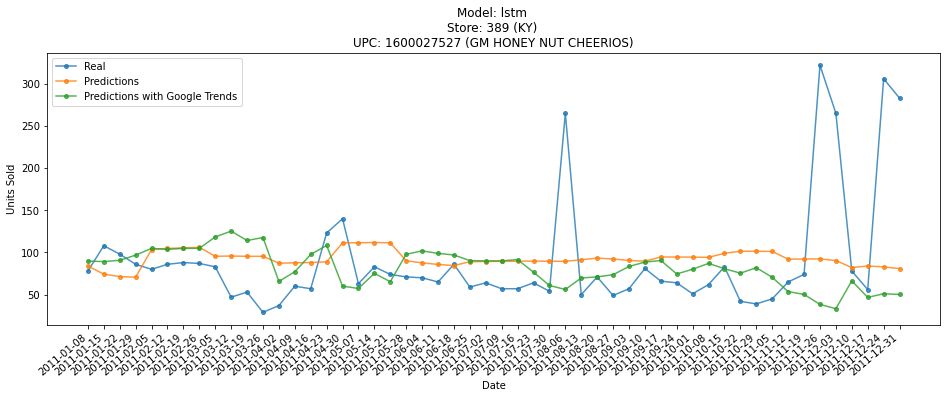

Std lstm: 9.34 and with Google Trends: 21.44






Std xgb: 23.20 and with Google Trends: 8.92


Std lstm: 11.39 and with Google Trends: 22.64






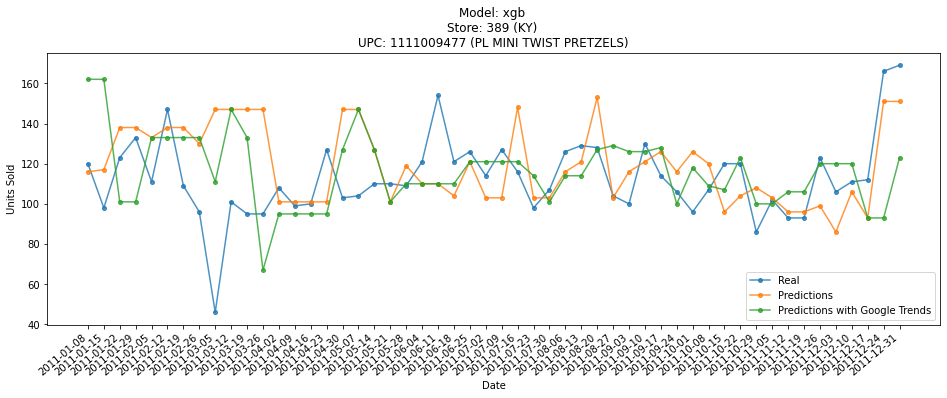

Std xgb: 19.06 and with Google Trends: 17.78


Std lstm: 4.08 and with Google Trends: 6.46






Std xgb: 19.05 and with Google Trends: 23.19


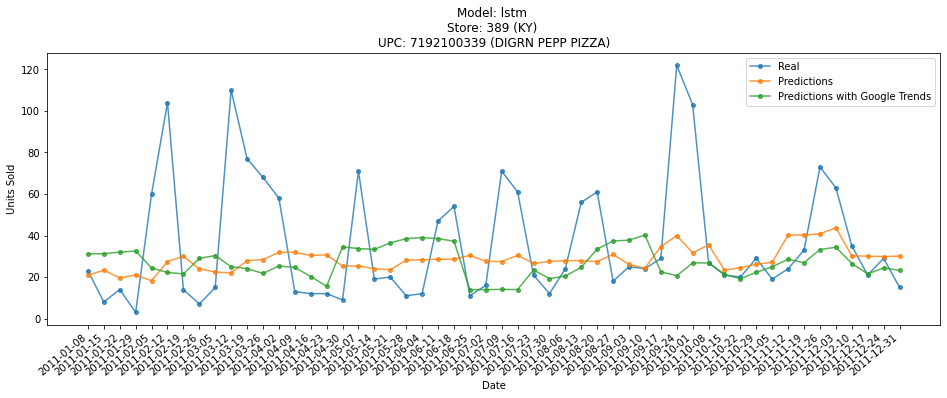

Std lstm: 5.46 and with Google Trends: 7.28






Std xgb: 36.25 and with Google Trends: 72.88


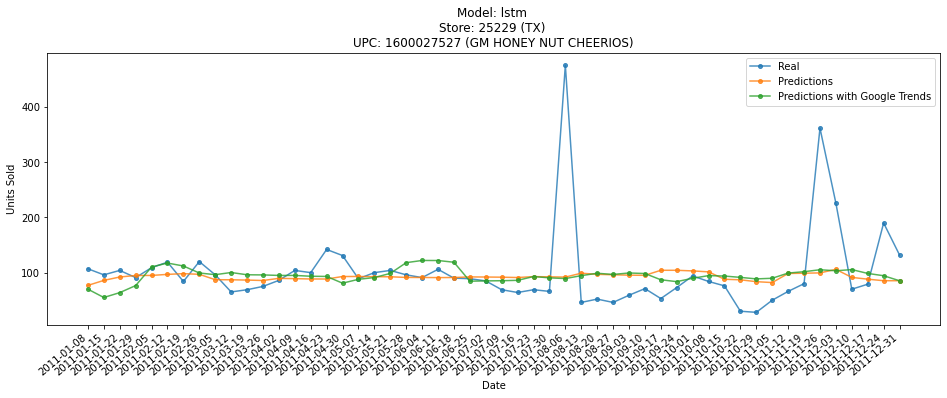

Std lstm: 5.94 and with Google Trends: 13.07






Std xgb: 31.43 and with Google Trends: 19.82


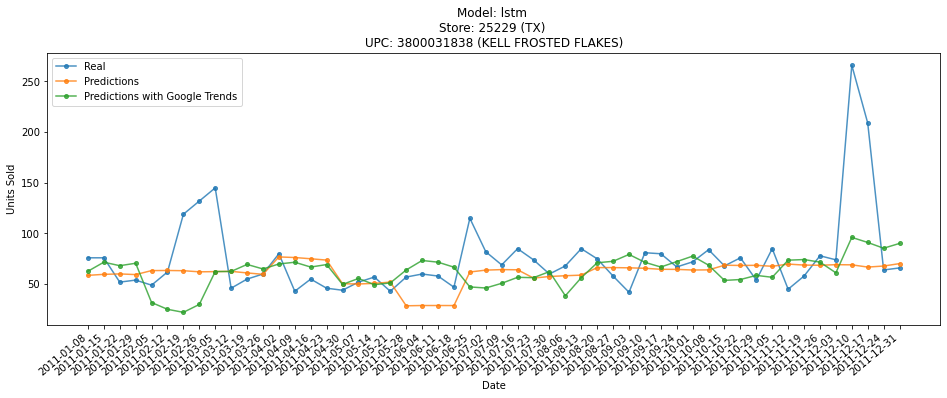

Std lstm: 11.17 and with Google Trends: 15.47






Std xgb: 13.15 and with Google Trends: 12.46


Std lstm: 3.07 and with Google Trends: 6.43






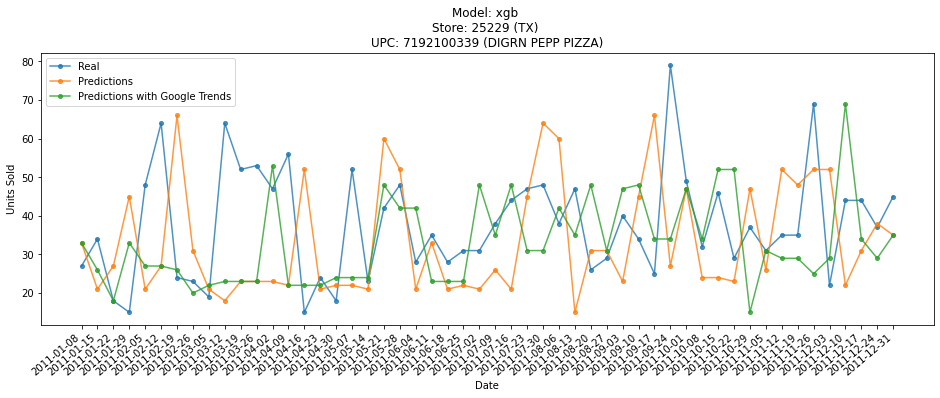

Std xgb: 14.55 and with Google Trends: 11.34


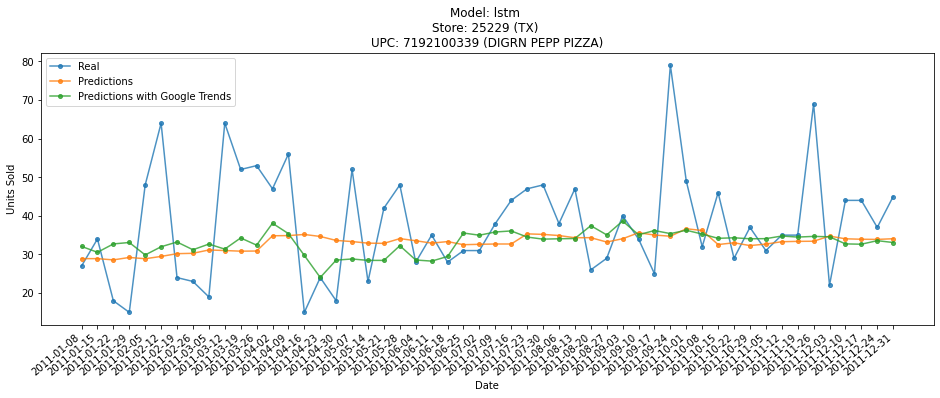

Std lstm: 2.03 and with Google Trends: 2.88






In [21]:
# Plot the forecast for each model

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(1,1, figsize=(16,5))
#         plt.figure(figsize=(16,8))
        plt.plot(temp['y_true'], marker='o', markersize=4, 
                 label='Real',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}'], marker='o', markersize=4, 
                 label='Predictions',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}_gtrend'], marker='o', markersize=4, 
                 label='Predictions with Google Trends',alpha=0.8)

        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        plt.title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        plt.xlabel('Date')
        plt.ylabel('Units Sold')
        plt.legend()
        for tick in axs.get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        plt.show()
        if model == 'xgb':
            print(f"Std xgb: {temp['y_pred_xgb'].std():.2f} and with Google Trends: {temp['y_pred_xgb_gtrend'].std():.2f}")
        if model == 'lstm':
            print(f"Std lstm: {temp['y_pred_lstm'].std():.2f} and with Google Trends: {temp['y_pred_lstm_gtrend'].std():.2f}")
        
    print('\n\n\n')


In [22]:
# When we add google trends, there seem to be more variation in the predictions

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Statistical tests

- H0: XGBoost and XGBoost_GoogleTrends have the same distribution. Likewise, LSTM and LSTM_GoogleTrends have the same distribution.
- If there is no statistical difference in the average MASE/RMSSE obtained between the two experiments we reject the null hypothesis. At the α = 0.05 level, if we get a p-value less than 0.05 we reject the null hypothesis. ( since the p-value is inferior to α ).

Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

In [23]:
from scipy import stats

In [24]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)
xgb_gtrend_hyp

model                   xgb  xgb_gtrend
store upc                              
389   1111009477  26.208484   26.461874
      1600027527  87.348110   83.708744
      3800031838  76.024035   70.360473
      7192100339  40.363969   38.393209
2277  1111009477  56.648715   57.745796
      1600027527  96.616609  106.533491
      3800031838  73.455245   66.392481
      7192100339  45.950224   51.437415
25229 1111009477  20.409274   20.659790
      1600027527  86.193767  100.766390
      3800031838  54.991957   47.809317
      7192100339  21.485684   17.599170

In [25]:
paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

In [27]:
paired_results.append(t_test_val)

xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)    26.2085    26.4619         -0.253390
(389, 1600027527)    87.3481    83.7087          3.639366
(389, 3800031838)     76.024    70.3605          5.663562
(389, 7192100339)     40.364    38.3932          1.970761
(2277, 1111009477)   56.6487    57.7458         -1.097081
(2277, 1600027527)   96.6166    106.533         -9.916881
(2277, 3800031838)   73.4552    66.3925          7.062764
(2277, 7192100339)   45.9502    51.4374         -5.487191
(25229, 1111009477)  20.4093    20.6598         -0.250516
(25229, 1600027527)  86.1938    100.766        -14.572624
(25229, 3800031838)   54.992    47.8093          7.182641
(25229, 7192100339)  21.4857    17.5992          3.886514
std                  26.8438    29.5661          6.792612
average              57.1413    57.3223         -0.181006
p_value                    -          -          0.928112

#### LSTM

In [28]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    20.7117     22.3306           -1.618926
(389, 1600027527)    70.3397     81.2478          -10.908142
(389, 3800031838)    68.3178     74.7623           -6.444538
(389, 7192100339)    29.7366      32.593           -2.856409
(2277, 1111009477)   47.3942     49.6486           -2.254439
(2277, 1600027527)   100.391      94.673            5.717792
(2277, 3800031838)   55.4538     57.0151           -1.561305
(2277, 7192100339)   36.4254     37.2443           -0.818937
(25229, 1111009477)  16.8868     18.9935           -2.106645
(25229, 1600027527)  73.1133     73.8437           -0.730382
(25229, 3800031838)  41.1832     41.5554           -0.372249
(25229, 7192100339)  14.7312     14.4764            0.254805
std                  26.4173      26.507            3.937621
average              47.8904     49.8653           -1.974948
p_value                    -           -            0.110186

### XGBoost MASE Statistical Test

In [29]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','mase','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='mase')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)     1.10071    1.14237         -0.041660
(389, 1600027527)    0.795395   0.829622         -0.034227
(389, 3800031838)       1.079   0.890333          0.188669
(389, 7192100339)     1.41622    1.47857         -0.062349
(2277, 1111009477)    1.50611    1.53932         -0.033204
(2277, 1600027527)   0.957258    1.06362         -0.106362
(2277, 3800031838)    1.21872    1.11128          0.107431
(2277, 7192100339)    1.23307    1.43858         -0.205511
(25229, 1111009477)   1.11704    1.09097          0.026073
(25229, 1600027527)   1.18749     1.5287         -0.341204
(25229, 3800031838)   1.05529   0.953871          0.101421
(25229, 7192100339)   1.26915   0.973833          0.295319
std                  0.191597   0.258218          0.171160
average               1.16129    1.17009         -0.008800
p_value                     -          -          0.861876

### T-Test MASE LSTM

In [30]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','mase','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='mase')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    0.918879    0.966799           -0.047920
(389, 1600027527)    0.899716    0.885572            0.014144
(389, 3800031838)     0.92189     1.18928           -0.267392
(389, 7192100339)     1.09111      1.1708           -0.079689
(2277, 1111009477)    1.18983     1.28039           -0.090552
(2277, 1600027527)    0.93431    0.855197            0.079112
(2277, 3800031838)   0.789534    0.826455           -0.036921
(2277, 7192100339)    1.05007     1.09128           -0.041211
(25229, 1111009477)   1.03598     1.10656           -0.070582
(25229, 1600027527)   1.00216     1.06887           -0.066705
(25229, 3800031838)  0.770789    0.881404           -0.110615
(25229, 7192100339)   0.85307    0.830626            0.022444
std                  0.123979    0.157862            0.085110
average              0.954779     1.01277           -0.057990
p_value                     -           -            0.037794

### xgboost RMSSE t-test

In [31]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmsse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmsse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)     1.12271    1.13357         -0.010855
(389, 1600027527)     0.73282   0.702287          0.030533
(389, 3800031838)     1.05548   0.976847          0.078630
(389, 7192100339)      1.2943     1.2311          0.063194
(2277, 1111009477)    1.42059     1.4481         -0.027512
(2277, 1600027527)   0.801183   0.883417         -0.082235
(2277, 3800031838)   0.979685   0.885488          0.094197
(2277, 7192100339)    1.10804    1.24036         -0.132318
(25229, 1111009477)   1.09229     1.1057         -0.013407
(25229, 1600027527)  0.999165    1.16809         -0.168927
(25229, 3800031838)  0.892055   0.775542          0.116514
(25229, 7192100339)   1.07666   0.881901          0.194755
std                  0.191439   0.220303          0.106025
average               1.04791    1.03603          0.011881
p_value                     -          -          0.705295

### LSTM rmsse t-test

In [32]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmsse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmsse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    0.887241    0.956592           -0.069351
(389, 1600027527)    0.590125    0.681641           -0.091515
(389, 3800031838)    0.948488     1.03796           -0.089472
(389, 7192100339)    0.953522     1.04511           -0.091593
(2277, 1111009477)    1.18851     1.24505           -0.056535
(2277, 1600027527)   0.832479    0.785065            0.047414
(2277, 3800031838)   0.739597     0.76042           -0.020823
(2277, 7192100339)    0.87836    0.898108           -0.019748
(25229, 1111009477)  0.903772     1.01652           -0.112746
(25229, 1600027527)  0.847535    0.856002           -0.008467
(25229, 3800031838)  0.668055    0.674094           -0.006038
(25229, 7192100339)  0.738186    0.725418            0.012768
std                  0.155413    0.175446            0.049986
average               0.84799    0.890165           -0.042176
p_value                     -           -            0.013867